In [1]:
# !conda install --quiet --yes tqdm

In [2]:
cd ..

/home/jovyan/portfolio/housing_model_development


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import lib.lm as lm
from lib.preprocessing import BoxCoxTransformer
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning

In [4]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [5]:
boston = load_boston()

In [6]:
X = pd.DataFrame(boston.data, columns=boston.feature_names)

In [7]:
y = boston.target

In [8]:
X.sample(4)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
205,0.13642,0.0,10.59,0.0,0.489,5.891,22.3,3.9454,4.0,277.0,18.6,396.9,10.87
385,16.81180,0.0,18.10,0.0,0.700,5.277,98.1,1.4261,24.0,666.0,20.2,396.9,30.81
49,0.21977,0.0,6.91,0.0,0.448,5.602,62.0,6.0877,3.0,233.0,17.9,396.9,16.20
54,0.01360,75.0,4.00,0.0,0.410,5.888,47.6,7.3197,3.0,469.0,21.1,396.9,14.80


## Baseline Model

Prior to any feature engineering, we will fit a baseline model using Ridge and Lasso Regressions with some regularization.

In [9]:
results = pd.DataFrame()

In [10]:
results, _, _ = \
    lm.simple_alpha_grid_search(make_pipeline(LinearRegression()), X, y, results)

100%|██████████| 10/10 [00:00<00:00, 126.14it/s]


In [11]:
results

,alpha,data_preprocessing,model,model_name,test_score,train_score
0,NaN,[],"Pipeline(steps=[('linearregression', LinearReg...",linearregression,0.717536,0.742157


In [12]:
results, train_scores, test_scores = \
    lm.simple_alpha_grid_search(make_pipeline(Lasso()), X, y, results)

100%|██████████| 10/10 [00:00<00:00, 141.53it/s]


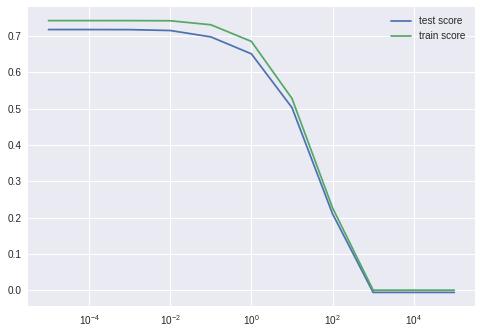

In [13]:
plt.plot(np.logspace(-5,5,11), test_scores, label='test score')
plt.plot(np.logspace(-5,5,11), train_scores, label='train score')
plt.xscale('log')
plt.legend()

In [14]:
results

,alpha,data_preprocessing,model,model_name,test_score,train_score
0,NaN,[],"Pipeline(steps=[('linearregression', LinearReg...",linearregression,0.717536,0.742157
0,0.00001,[],"Pipeline(steps=[('lasso', Lasso(alpha=1.000000...",lasso,0.717534,0.742157


In [15]:
results, train_scores, test_scores = \
    lm.simple_alpha_grid_search(make_pipeline(Ridge()), X, y, results)

100%|██████████| 10/10 [00:00<00:00, 175.77it/s]


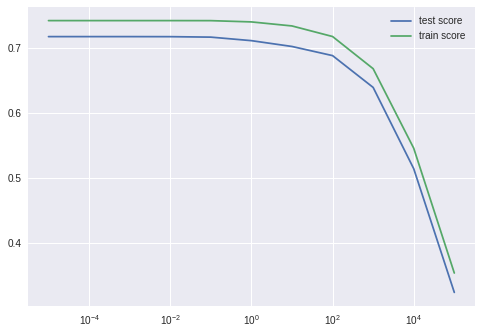

In [16]:
plt.plot(np.logspace(-5,5,11), test_scores, label='test score')
plt.plot(np.logspace(-5,5,11), train_scores, label='train score')
plt.xscale('log')
plt.legend()

In [17]:
results

,alpha,data_preprocessing,model,model_name,test_score,train_score
0,NaN,[],"Pipeline(steps=[('linearregression', LinearReg...",linearregression,0.717536,0.742157
0,0.00001,[],"Pipeline(steps=[('lasso', Lasso(alpha=1.000000...",lasso,0.717534,0.742157
0,0.00001,[],"Pipeline(steps=[('ridge', Ridge(alpha=1.000000...",ridge,0.717536,0.742157


## Standardization

Regularized linear models require standardization and possibly skew normalization to function properly.

In [18]:
from scipy.stats import skew
samp_stats = X.describe().T
samp_stats['skew'] = skew(X)
samp_stats

,count,mean,std,min,25%,50%,75%,max,skew
CRIM,506.0,3.593761,8.596783,0.00632,0.082045,0.25651,3.647423,88.9762,5.222039
ZN,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000,2.219063
INDUS,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400,0.294146
CHAS,506.0,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000,3.395799
NOX,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710,0.727144
RM,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800,0.402415
AGE,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000,-0.597186
DIS,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265,1.008779
RAD,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000,1.001833
TAX,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000,0.667968


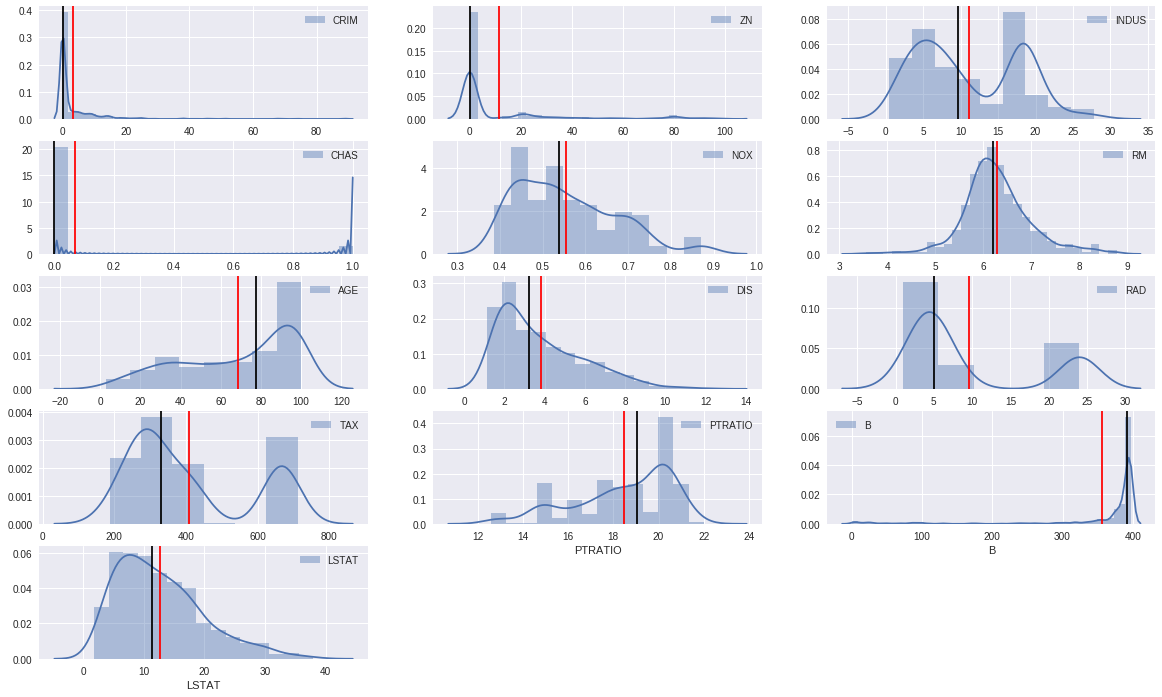

In [19]:
fig = plt.figure(figsize=(20,12))
for i, col in enumerate(boston.feature_names):
    fig.add_subplot(5,3,1+i)
    sns.distplot(X[col], label=col)
    plt.axvline(X[col].mean(), c='red')
    plt.axvline(X[col].median(), c='black')
    plt.legend()

In [20]:
results, _, _ = \
    lm.simple_alpha_grid_search(make_pipeline(StandardScaler(), LinearRegression()), X, y, results)

100%|██████████| 10/10 [00:00<00:00, 112.35it/s]


In [21]:
results

,alpha,data_preprocessing,model,model_name,test_score,train_score
0,NaN,[],"Pipeline(steps=[('linearregression', LinearReg...",linearregression,0.717536,0.742157
0,0.00001,[],"Pipeline(steps=[('lasso', Lasso(alpha=1.000000...",lasso,0.717534,0.742157
0,0.00001,[],"Pipeline(steps=[('ridge', Ridge(alpha=1.000000...",ridge,0.717536,0.742157
0,NaN,[standardscaler],"Pipeline(steps=[('standardscaler', StandardSca...",linearregression,0.717536,0.742157


In [22]:
results, _, _ = \
    lm.simple_alpha_grid_search(make_pipeline(StandardScaler(), Lasso()), X, y, results)

100%|██████████| 10/10 [00:00<00:00, 250.41it/s]


In [23]:
results, _, _ = \
    lm.simple_alpha_grid_search(make_pipeline(StandardScaler(), Ridge()), X, y, results)

100%|██████████| 10/10 [00:00<00:00, 311.52it/s]


In [24]:
results

,alpha,data_preprocessing,model,model_name,test_score,train_score
0,NaN,[],"Pipeline(steps=[('linearregression', LinearReg...",linearregression,0.717536,0.742157
0,0.00001,[],"Pipeline(steps=[('lasso', Lasso(alpha=1.000000...",lasso,0.717534,0.742157
0,0.00001,[],"Pipeline(steps=[('ridge', Ridge(alpha=1.000000...",ridge,0.717536,0.742157
0,NaN,[standardscaler],"Pipeline(steps=[('standardscaler', StandardSca...",linearregression,0.717536,0.742157
0,0.00001,[standardscaler],"Pipeline(steps=[('standardscaler', StandardSca...",lasso,0.717536,0.742157
0,0.00001,[standardscaler],"Pipeline(steps=[('standardscaler', StandardSca...",ridge,0.717536,0.742157


In [25]:
X.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


In [26]:
X_bc = X+1E-9
results, _, _ = \
    lm.simple_alpha_grid_search(make_pipeline(BoxCoxTransformer(), StandardScaler(), LinearRegression()), X_bc, y, results)

100%|██████████| 10/10 [00:00<00:00, 28.63it/s]


In [27]:
results

,alpha,data_preprocessing,model,model_name,test_score,train_score
0,NaN,[],"Pipeline(steps=[('linearregression', LinearReg...",linearregression,0.717536,0.742157
0,0.00001,[],"Pipeline(steps=[('lasso', Lasso(alpha=1.000000...",lasso,0.717534,0.742157
0,0.00001,[],"Pipeline(steps=[('ridge', Ridge(alpha=1.000000...",ridge,0.717536,0.742157
0,NaN,[standardscaler],"Pipeline(steps=[('standardscaler', StandardSca...",linearregression,0.717536,0.742157
0,0.00001,[standardscaler],"Pipeline(steps=[('standardscaler', StandardSca...",lasso,0.717536,0.742157
0,0.00001,[standardscaler],"Pipeline(steps=[('standardscaler', StandardSca...",ridge,0.717536,0.742157
0,NaN,"[boxcoxtransformer, standardscaler]","Pipeline(steps=[('boxcoxtransformer', BoxCoxTr...",linearregression,0.769327,0.774756


In [28]:
results, _, _ = \
    lm.simple_alpha_grid_search(make_pipeline(BoxCoxTransformer(), StandardScaler(), Lasso()), X_bc, y, results)

100%|██████████| 10/10 [00:00<00:00, 24.09it/s]


In [29]:
results, _, _ = \
    lm.simple_alpha_grid_search(make_pipeline(BoxCoxTransformer(), StandardScaler(), Ridge()), X_bc, y, results)

100%|██████████| 10/10 [00:00<00:00, 30.37it/s]


In [30]:
results

,alpha,data_preprocessing,model,model_name,test_score,train_score
0,NaN,[],"Pipeline(steps=[('linearregression', LinearReg...",linearregression,0.717536,0.742157
0,0.00001,[],"Pipeline(steps=[('lasso', Lasso(alpha=1.000000...",lasso,0.717534,0.742157
0,0.00001,[],"Pipeline(steps=[('ridge', Ridge(alpha=1.000000...",ridge,0.717536,0.742157
0,NaN,[standardscaler],"Pipeline(steps=[('standardscaler', StandardSca...",linearregression,0.717536,0.742157
0,0.00001,[standardscaler],"Pipeline(steps=[('standardscaler', StandardSca...",lasso,0.717536,0.742157
0,0.00001,[standardscaler],"Pipeline(steps=[('standardscaler', StandardSca...",ridge,0.717536,0.742157
0,NaN,"[boxcoxtransformer, standardscaler]","Pipeline(steps=[('boxcoxtransformer', BoxCoxTr...",linearregression,0.769327,0.774756
0,0.00001,"[boxcoxtransformer, standardscaler]","Pipeline(steps=[('boxcoxtransformer', BoxCoxTr...",lasso,0.769327,0.774756
0,0.00001,"[boxcoxtransformer, standardscaler]","Pipeline(steps=[('boxcoxtransformer', BoxCoxTr...",ridge,0.769327,0.774756


## Basic EDA

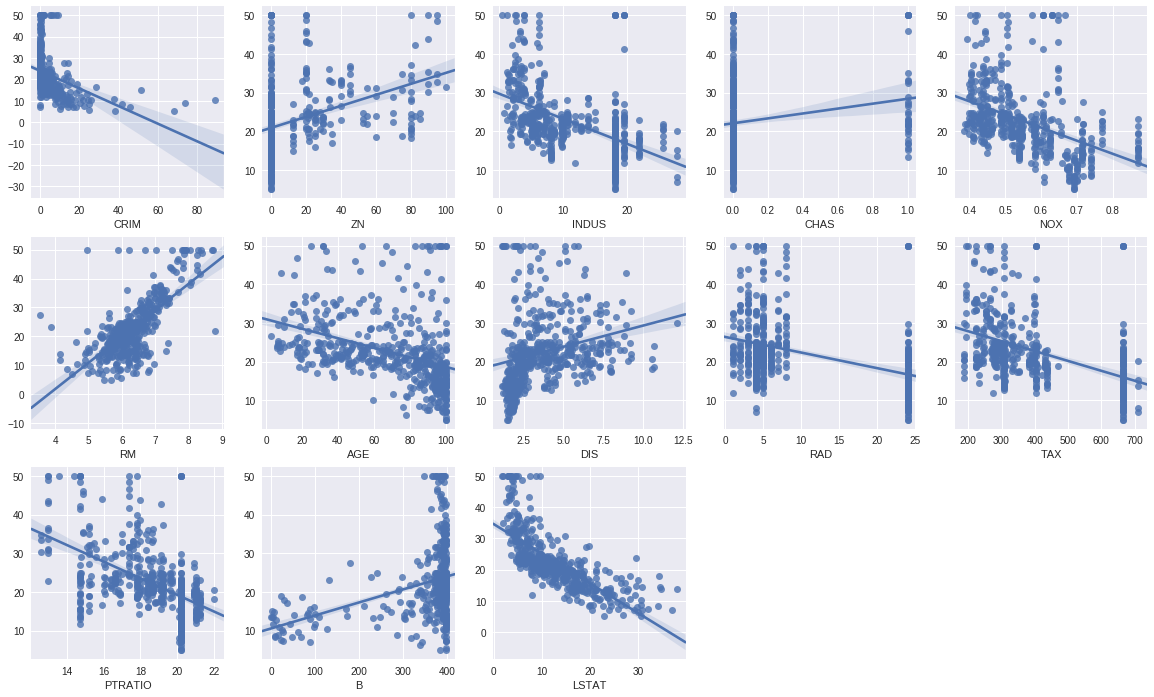

In [31]:
fig = plt.figure(figsize=(20,12))
for i, col in enumerate(boston.feature_names):
    fig.add_subplot(3,5,1+i)
    sns.regplot(col, y, data=X)

From the appearance of these plots, many of these features would lend themselves to discretization.

In [32]:
for col in X:
    print("{:10} {:8} {}".format(col, str(X[col].dtype), len(X[col].unique())))

CRIM       float64  504
ZN         float64  26
INDUS      float64  76
CHAS       float64  2
NOX        float64  81
RM         float64  446
AGE        float64  356
DIS        float64  412
RAD        float64  9
TAX        float64  66
PTRATIO    float64  46
B          float64  357
LSTAT      float64  455


From this, on this small dataset, `ZN`, `INDUS`, `CHAS`, `NOX`, `RAD`, `TAX`, and `PTRATIO` can be immediately treated as categorical variables.

In [33]:
X_cat = X.copy()

In [34]:
for col in ['ZN', 'INDUS', 'CHAS', 'NOX', 'RAD', 'TAX', 'PTRATIO']:
    X_cat[col] = X_cat[col].astype('category')

In [35]:
for col in X_cat:
    print("{:10} {:8} {}".format(col, str(X_cat[col].dtype), len(X_cat[col].unique())))

CRIM       float64  504
ZN         category 26
INDUS      category 76
CHAS       category 2
NOX        category 81
RM         float64  446
AGE        float64  356
DIS        float64  412
RAD        category 9
TAX        category 66
PTRATIO    category 46
B          float64  357
LSTAT      float64  455


In [36]:
X_cat = pd.get_dummies(X_cat, sparse=True)

In [37]:
X_cat += 1E-9

In [38]:
X.shape, X_cat.shape

((506, 13), (506, 312))

## Next Model

In [39]:
results, _, _ = \
    lm.simple_alpha_grid_search(make_pipeline(BoxCoxTransformer(), StandardScaler(), LinearRegression()), 
                                X_cat, y, results)

100%|██████████| 10/10 [00:15<00:00,  1.54s/it]


In [40]:
results

,alpha,data_preprocessing,model,model_name,test_score,train_score
0,NaN,[],"Pipeline(steps=[('linearregression', LinearReg...",linearregression,7.175363e-01,0.742157
0,0.00001,[],"Pipeline(steps=[('lasso', Lasso(alpha=1.000000...",lasso,7.175341e-01,0.742157
0,0.00001,[],"Pipeline(steps=[('ridge', Ridge(alpha=1.000000...",ridge,7.175362e-01,0.742157
0,NaN,[standardscaler],"Pipeline(steps=[('standardscaler', StandardSca...",linearregression,7.175363e-01,0.742157
0,0.00001,[standardscaler],"Pipeline(steps=[('standardscaler', StandardSca...",lasso,7.175363e-01,0.742157
0,0.00001,[standardscaler],"Pipeline(steps=[('standardscaler', StandardSca...",ridge,7.175363e-01,0.742157
0,NaN,"[boxcoxtransformer, standardscaler]","Pipeline(steps=[('boxcoxtransformer', BoxCoxTr...",linearregression,7.693274e-01,0.774756
0,0.00001,"[boxcoxtransformer, standardscaler]","Pipeline(steps=[('boxcoxtransformer', BoxCoxTr...",lasso,7.693269e-01,0.774756
0,0.00001,"[boxcoxtransformer, standardscaler]","Pipeline(steps=[('boxcoxtransformer', BoxCoxTr...",ridge,7.693274e-01,0.774756
0,NaN,"[boxcoxtransformer, standardscaler]","Pipeline(steps=[('boxcoxtransformer', BoxCoxTr...",linearregression,-1.017961e+53,0.892456


In [41]:
results, _, _ = \
    lm.simple_alpha_grid_search(make_pipeline(BoxCoxTransformer(), StandardScaler(), Lasso()), 
                                X_cat, y, results)

100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


In [42]:
results

,alpha,data_preprocessing,model,model_name,test_score,train_score
0,NaN,[],"Pipeline(steps=[('linearregression', LinearReg...",linearregression,7.175363e-01,0.742157
0,0.00001,[],"Pipeline(steps=[('lasso', Lasso(alpha=1.000000...",lasso,7.175341e-01,0.742157
0,0.00001,[],"Pipeline(steps=[('ridge', Ridge(alpha=1.000000...",ridge,7.175362e-01,0.742157
0,NaN,[standardscaler],"Pipeline(steps=[('standardscaler', StandardSca...",linearregression,7.175363e-01,0.742157
0,0.00001,[standardscaler],"Pipeline(steps=[('standardscaler', StandardSca...",lasso,7.175363e-01,0.742157
0,0.00001,[standardscaler],"Pipeline(steps=[('standardscaler', StandardSca...",ridge,7.175363e-01,0.742157
0,NaN,"[boxcoxtransformer, standardscaler]","Pipeline(steps=[('boxcoxtransformer', BoxCoxTr...",linearregression,7.693274e-01,0.774756
0,0.00001,"[boxcoxtransformer, standardscaler]","Pipeline(steps=[('boxcoxtransformer', BoxCoxTr...",lasso,7.693269e-01,0.774756
0,0.00001,"[boxcoxtransformer, standardscaler]","Pipeline(steps=[('boxcoxtransformer', BoxCoxTr...",ridge,7.693274e-01,0.774756
0,NaN,"[boxcoxtransformer, standardscaler]","Pipeline(steps=[('boxcoxtransformer', BoxCoxTr...",linearregression,-1.017961e+53,0.892456


In [43]:
results, _, _ = \
    lm.simple_alpha_grid_search(make_pipeline(BoxCoxTransformer(), StandardScaler(), Ridge()), 
                                X_cat, y, results)

100%|██████████| 10/10 [00:13<00:00,  1.40s/it]


In [44]:
results

,alpha,data_preprocessing,model,model_name,test_score,train_score
0,NaN,[],"Pipeline(steps=[('linearregression', LinearReg...",linearregression,7.175363e-01,0.742157
0,0.00001,[],"Pipeline(steps=[('lasso', Lasso(alpha=1.000000...",lasso,7.175341e-01,0.742157
0,0.00001,[],"Pipeline(steps=[('ridge', Ridge(alpha=1.000000...",ridge,7.175362e-01,0.742157
0,NaN,[standardscaler],"Pipeline(steps=[('standardscaler', StandardSca...",linearregression,7.175363e-01,0.742157
0,0.00001,[standardscaler],"Pipeline(steps=[('standardscaler', StandardSca...",lasso,7.175363e-01,0.742157
0,0.00001,[standardscaler],"Pipeline(steps=[('standardscaler', StandardSca...",ridge,7.175363e-01,0.742157
0,NaN,"[boxcoxtransformer, standardscaler]","Pipeline(steps=[('boxcoxtransformer', BoxCoxTr...",linearregression,7.693274e-01,0.774756
0,0.00001,"[boxcoxtransformer, standardscaler]","Pipeline(steps=[('boxcoxtransformer', BoxCoxTr...",lasso,7.693269e-01,0.774756
0,0.00001,"[boxcoxtransformer, standardscaler]","Pipeline(steps=[('boxcoxtransformer', BoxCoxTr...",ridge,7.693274e-01,0.774756
0,NaN,"[boxcoxtransformer, standardscaler]","Pipeline(steps=[('boxcoxtransformer', BoxCoxTr...",linearregression,-1.017961e+53,0.892456


### Grid-Search Over Lasso to identify important features

In [45]:
from sklearn.model_selection import GridSearchCV, train_test_split

In [46]:
gs = GridSearchCV(make_pipeline(BoxCoxTransformer(), StandardScaler(), Lasso()), 
                  {'lasso__alpha': np.logspace(-9,9,19)})
X_cat_train, X_cat_test, y_train, y_test = train_test_split(X_cat, y)
gs.fit(X_cat_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('boxcoxtransformer', BoxCoxTransformer(copy=True, n_jobs=1, transformed_features='all')), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'lasso__alpha': array([  1.00000e-09,   1.00000e-08,   1.00000e-07,   1.00000e-06,
         1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03,   1.00000e+04,   1.00000e+05,   1.00000e+06,
         1.00000e+07,   1.00000e+08,   1.00000e+09])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

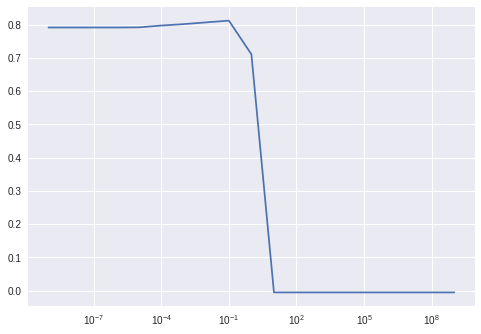

In [47]:
cv_res = pd.DataFrame(gs.cv_results_)
plt.plot(np.logspace(-9,9,19), cv_res.mean_test_score)
plt.xscale('log')

In [48]:
gs = GridSearchCV(make_pipeline(BoxCoxTransformer(), StandardScaler(), Lasso()), 
                  {'lasso__alpha': np.logspace(-2,1,19)})
X_cat_train, X_cat_test, y_train, y_test = train_test_split(X_cat, y)
gs.fit(X_cat_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('boxcoxtransformer', BoxCoxTransformer(copy=True, n_jobs=1, transformed_features='all')), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'lasso__alpha': array([  0.01   ,   0.01468,   0.02154,   0.03162,   0.04642,   0.06813,
         0.1    ,   0.14678,   0.21544,   0.31623,   0.46416,   0.68129,
         1.     ,   1.4678 ,   2.15443,   3.16228,   4.64159,   6.81292,
        10.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

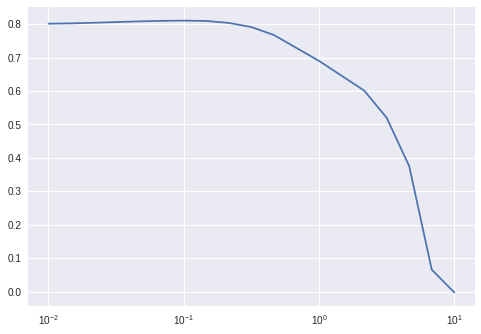

In [49]:
cv_res = pd.DataFrame(gs.cv_results_)
plt.plot(np.logspace(-2,1,19), cv_res.mean_test_score)
plt.xscale('log')

(0, 1)

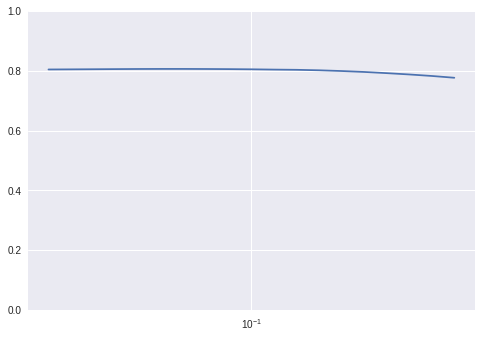

In [50]:
gs = GridSearchCV(make_pipeline(BoxCoxTransformer(), StandardScaler(), Lasso()), 
                  {'lasso__alpha': np.logspace(-1.5,-0.5,19)})
X_cat_train, X_cat_test, y_train, y_test = train_test_split(X_cat, y)
gs.fit(X_cat_train, y_train)

cv_res = pd.DataFrame(gs.cv_results_)
plt.plot(np.logspace(-1.5,-0.5,19), cv_res.mean_test_score)
plt.xscale('log')
plt.ylim(0,1)

In [51]:
cv_res.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
mean_fit_time,0.706008,0.710182,0.661489,0.690633,0.69697,0.698243,0.729896,0.717194,0.726978,0.692705,0.69653,0.687949,0.715472,0.695647,0.663068,0.654938,0.653761,0.658681,0.658939
mean_score_time,0.037928,0.0397063,0.0327316,0.0344378,0.0354106,0.0330461,0.0337126,0.0418743,0.0353413,0.0327899,0.0345736,0.0363365,0.0339034,0.0458059,0.0344889,0.033497,0.0304443,0.0354748,0.0324987
mean_test_score,0.804492,0.804867,0.805285,0.805737,0.80611,0.806308,0.806322,0.806065,0.805673,0.805055,0.804112,0.803387,0.801779,0.799296,0.796193,0.792206,0.787813,0.782774,0.776775
mean_train_score,0.931392,0.931119,0.930779,0.930339,0.929785,0.929111,0.928257,0.927174,0.925829,0.924139,0.92202,0.91953,0.916481,0.912849,0.908411,0.903058,0.896695,0.889327,0.880647
param_lasso__alpha,0.0316228,0.0359381,0.0408424,0.0464159,0.05275,0.0599484,0.0681292,0.0774264,0.0879923,0.1,0.113646,0.129155,0.14678,0.16681,0.189574,0.215443,0.244844,0.278256,0.316228
params,{'lasso__alpha': 0.0316227766017},{'lasso__alpha': 0.035938136638},{'lasso__alpha': 0.0408423865267},{'lasso__alpha': 0.0464158883361},{'lasso__alpha': 0.052749970637},{'lasso__alpha': 0.0599484250319},{'lasso__alpha': 0.0681292069058},{'lasso__alpha': 0.0774263682681},{'lasso__alpha': 0.0879922543569},{'lasso__alpha': 0.1},{'lasso__alpha': 0.113646366639},{'lasso__alpha': 0.129154966501},{'lasso__alpha': 0.146779926762},{'lasso__alpha': 0.16681005372},{'lasso__alpha': 0.189573565241},{'lasso__alpha': 0.215443469003},{'lasso__alpha': 0.244843674682},{'lasso__alpha': 0.278255940221},{'lasso__alpha': 0.316227766017}
rank_test_score,10,9,7,5,3,2,1,4,6,8,11,12,13,14,15,16,17,18,19
split0_test_score,0.742438,0.743726,0.745153,0.746793,0.748525,0.750198,0.751858,0.753305,0.754798,0.756023,0.757278,0.758391,0.757797,0.75534,0.752152,0.747909,0.743999,0.740029,0.73554
split0_train_score,0.931783,0.931528,0.931207,0.930792,0.930269,0.929616,0.928792,0.927747,0.926437,0.924754,0.922637,0.919961,0.916849,0.913206,0.908918,0.903698,0.897484,0.890337,0.88207
split1_test_score,0.858634,0.858465,0.858335,0.858178,0.857885,0.857263,0.856414,0.855182,0.853649,0.851584,0.848609,0.84669,0.84444,0.8419,0.838836,0.835477,0.831375,0.826327,0.820932


In [70]:
lasso_coefs = []
for alpha in cv_res.param_lasso__alpha:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_cat, y)
    lasso_coefs.append(lasso.coef_)

In [71]:
lasso_coefs = pd.DataFrame(np.array(lasso_coefs))
lasso_coefs.shape

(19, 312)

In [72]:
lasso_coefs.describe()

,0,1,2,3,4,5,6,7,8,9,...,302,303,304,305,306,307,308,309,310,311
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.0,19.0,19.0,...,19.0,19.0,19.0,19.0,19.000000,19.0,19.000000,19.0,19.0,19.0
mean,-0.075210,4.993661,-0.032896,-0.879123,0.012077,-0.504694,-1.906481,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.342805,0.0,-0.217815,0.0,0.0,0.0
std,0.019691,0.473782,0.011696,0.064525,0.001271,0.097937,0.625774,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.255937,0.0,0.215084,0.0,0.0,0.0
min,-0.097316,4.214744,-0.049504,-0.958620,0.010706,-0.646413,-2.516333,0.0,0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.591332,-0.0,-0.550328,-0.0,-0.0,-0.0
25%,-0.092305,4.553295,-0.042791,-0.912558,0.011035,-0.599356,-2.347703,0.0,0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.536445,-0.0,-0.403150,-0.0,-0.0,-0.0
50%,-0.083444,5.086449,-0.034326,-0.890143,0.011487,-0.492582,-2.158730,0.0,0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.511923,-0.0,-0.228301,-0.0,-0.0,-0.0
75%,-0.056133,5.456954,-0.022336,-0.869192,0.013286,-0.416358,-1.659364,0.0,0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.000000,-0.0,-0.0,-0.0
max,-0.044025,5.504005,-0.015252,-0.690222,0.014074,-0.373883,-0.359164,0.0,0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.000000,-0.0,-0.0,-0.0


In [88]:
non_zero_coefs = lasso_coefs.T[lasso_coefs.abs().sum() > 0].index
zero_coefs = lasso_coefs.T[lasso_coefs.abs().sum() == 0].index

In [87]:
non_zero_coefs

Int64Index([  0,   1,   2,   3,   4,   5,   6,  10,  13,  29,  30,  52,  66,
             84,  96,  98, 105, 108, 109, 125, 145, 149, 153, 165, 172, 173,
            176, 177, 180, 181, 182, 183, 184, 186, 188, 191, 192, 193, 194,
            195, 196, 202, 204, 220, 223, 224, 225, 235, 238, 262, 267, 270,
            274, 287, 306, 308],
           dtype='int64')

In [90]:
len(zero_coefs)

256

### Use Lasso to Reduce size of dataset

In [93]:
lasso_coefs.T.index

RangeIndex(start=0, stop=312, step=1)

In [94]:
X_cat_red = X_cat.copy()

In [96]:
X_cat_red.columns = lasso_coefs.T.index

In [98]:
for col in zero_coefs:
    X_cat_red.drop(col, axis=1, inplace=True)

In [99]:
X_cat_red.shape

(506, 56)

## Principal Component Analysis

In [100]:
from sklearn.decomposition import PCA

In [101]:
pca = PCA()
pca_red = PCA()

In [102]:
pca.fit(X_cat)
pca_red.fit(X_cat_red)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

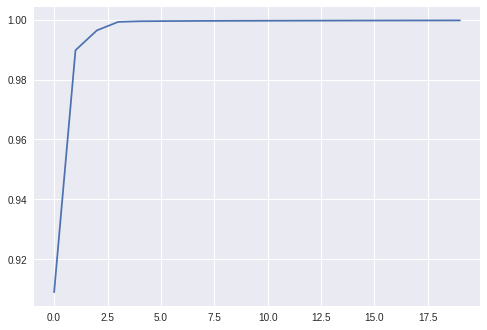

In [105]:
plt.plot(np.cumsum(pca.explained_variance_ratio_)[:20])

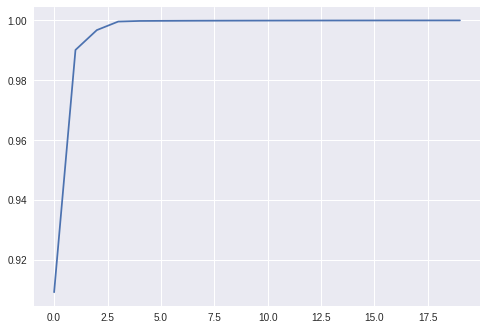

In [106]:
plt.plot(np.cumsum(pca_red.explained_variance_ratio_)[:20])

## PCA Model

In [123]:
gs = GridSearchCV(make_pipeline(BoxCoxTransformer(), 
                                StandardScaler(), 
                                PCA(),
                                Lasso(alpha=0.01)), 
                  {})
X_cat_train, X_cat_test, y_train, y_test = train_test_split(X_cat, y)
gs.fit(X_cat_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('boxcoxtransformer', BoxCoxTransformer(copy=True, n_jobs=1, transformed_features='all')), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=Fal...e=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [124]:
gs.score(X_cat_test, y_test)

0.82109907886435152

In [125]:
gs_red = GridSearchCV(make_pipeline(BoxCoxTransformer(), 
                                StandardScaler(), 
                                PCA(),
                                Lasso(alpha=0.01)), 
                  {})
X_cat_red_train, X_cat_red_test, y_train, y_test = train_test_split(X_cat_red, y)
gs_red.fit(X_cat_red_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('boxcoxtransformer', BoxCoxTransformer(copy=True, n_jobs=1, transformed_features='all')), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=Fal...e=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [128]:
gs_red.score(X_cat_red_test, y_test)

0.79480211684355728

## Final GridSearch


In [129]:
gs = GridSearchCV(make_pipeline(BoxCoxTransformer(), 
                                StandardScaler(), 
                                PCA(),
                                Lasso(alpha=0.01)), 
                  {'lasso__alpha': np.logspace(-9,9,19)})
X_cat_train, X_cat_test, y_train, y_test = train_test_split(X_cat, y)
gs.fit(X_cat_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('boxcoxtransformer', BoxCoxTransformer(copy=True, n_jobs=1, transformed_features='all')), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=Fal...e=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'lasso__alpha': array([  1.00000e-09,   1.00000e-08,   1.00000e-07,   1.00000e-06,
         1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03,   1.00000e+04,   1.00000e+05,   1.00000e+06,
         1.00000e+07,   1.00000e+08,   1.00000e+09])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [131]:
pd.DataFrame(gs.cv_results_).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
mean_fit_time,0.685434,0.676372,0.67072,0.662933,0.681685,0.687831,0.718079,0.68061,0.69207,0.663472,0.78693,0.73217,0.768258,0.706492,0.700223,0.674813,0.670617,0.672013,0.670307
mean_score_time,0.0659797,0.0450752,0.0454433,0.0450689,0.0442282,0.0547454,0.045257,0.0479446,0.0514229,0.0513595,0.054177,0.0599725,0.0547175,0.0519957,0.0604047,0.0465204,0.0463955,0.0478319,0.0455784
mean_test_score,0.736544,0.736544,0.736544,0.736545,0.736553,0.736633,0.73743,0.744761,0.766619,0.601004,0.147899,-0.017909,-0.017909,-0.017909,-0.017909,-0.017909,-0.017909,-0.017909,-0.017909
mean_train_score,0.926712,0.926712,0.926712,0.926712,0.926712,0.926712,0.926709,0.926504,0.919337,0.701005,0.172029,0,0,0,0,0,0,0,0
param_lasso__alpha,1e-09,1e-08,1e-07,1e-06,1e-05,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000,1e+06,1e+07,1e+08,1e+09
params,{'lasso__alpha': 1e-09},{'lasso__alpha': 1e-08},{'lasso__alpha': 1e-07},{'lasso__alpha': 1e-06},{'lasso__alpha': 1e-05},{'lasso__alpha': 0.0001},{'lasso__alpha': 0.001},{'lasso__alpha': 0.01},{'lasso__alpha': 0.1},{'lasso__alpha': 1.0},{'lasso__alpha': 10.0},{'lasso__alpha': 100.0},{'lasso__alpha': 1000.0},{'lasso__alpha': 10000.0},{'lasso__alpha': 100000.0},{'lasso__alpha': 1000000.0},{'lasso__alpha': 10000000.0},{'lasso__alpha': 100000000.0},{'lasso__alpha': 1000000000.0}
rank_test_score,9,8,7,6,5,4,3,2,1,10,11,12,12,12,12,12,12,12,12
split0_test_score,0.601954,0.601954,0.601954,0.601956,0.601973,0.602149,0.6039,0.620638,0.699094,0.662179,0.175271,-0.0311072,-0.0311072,-0.0311072,-0.0311072,-0.0311072,-0.0311072,-0.0311072,-0.0311072
split0_train_score,0.940954,0.940954,0.940954,0.940954,0.940954,0.940954,0.940952,0.940762,0.93439,0.738913,0.188453,0,0,0,0,0,0,0,0
split1_test_score,0.787469,0.787469,0.787469,0.78747,0.787474,0.787513,0.787902,0.79118,0.781041,0.561672,0.139547,-8.12257e-05,-8.12257e-05,-8.12257e-05,-8.12257e-05,-8.12257e-05,-8.12257e-05,-8.12257e-05,-8.12257e-05


In [132]:
gs = GridSearchCV(make_pipeline(BoxCoxTransformer(), 
                                StandardScaler(), 
                                PCA(),
                                Lasso(alpha=0.1)), 
                  {})
X_cat_train, X_cat_test, y_train, y_test = train_test_split(X_cat, y)
gs.fit(X_cat_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('boxcoxtransformer', BoxCoxTransformer(copy=True, n_jobs=1, transformed_features='all')), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=Fal...e=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [133]:
gs.cv_results_

{'mean_fit_time': array([ 0.69879651]),
 'mean_score_time': array([ 0.05014451]),
 'mean_test_score': array([ 0.77939266]),
 'mean_train_score': array([ 0.91851426]),
 'params': ({},),
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([ 0.80503726]),
 'split0_train_score': array([ 0.91946207]),
 'split1_test_score': array([ 0.80715345]),
 'split1_train_score': array([ 0.91342833]),
 'split2_test_score': array([ 0.72578374]),
 'split2_train_score': array([ 0.92265238]),
 'std_fit_time': array([ 0.04435406]),
 'std_score_time': array([ 0.00615553]),
 'std_test_score': array([ 0.03784212]),
 'std_train_score': array([ 0.00382488])}

In [ ]:
s